## Image recognition

The goals is:

* Put into practice NNs specially conceived for analysing images. Design and optimize the parameters of a Convolutional Neural Net (CNN) to deal with previous FFNN Model



In [1]:
!git clone https://github.com/KairoSagewing5/DeepLearning2023.git

Cloning into 'DeepLearning2023'...
remote: Enumerating objects: 44982, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 44982 (delta 2), reused 8 (delta 2), pack-reused 44973
Receiving objects: 100% (44982/44982), 1.64 GiB | 17.88 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (44967/44967), done.


In [2]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 76.4 MB/s eta 0:00:00


In [3]:
import uuid
import numpy as np

class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [4]:
categories = {0: 'CARGO_PLANE', 1: 'HELICOPTER', 2: 'SMALL_CAR', 3: 'BUS', 4: 'TRUCK', 5: 'MOTORBOAT', 6: 'FISHING_VESSEL', 7: 'DUMP_TRUCK', 8: 'EXCAVATOR', 9: 'BUILDING', 10: 'STORAGE_TANK', 11: 'SHIPPING_CONTAINER'}

In [5]:
import warnings
import rasterio
import numpy as np

def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    src_raster = rasterio.open(filename, 'r')
    # RasterIO to OpenCV (see inconsistencies between libjpeg and libjpeg-turbo)
    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img

def generator_images(objs, batch_size, do_shuffle=False):
    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i+batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels = [], []
            for (filename, obj) in group:
                # Load image
                images.append(load_geoimage(filename))
                probabilities = np.zeros(len(categories))
                probabilities[list(categories.values()).index(obj.category)] = 1
                labels.append(probabilities)
            images = np.array(images).astype(np.float32)
            labels = np.array(labels).astype(np.float32)
            yield images, labels

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show(fig)

#### Training
Design and train a ffNN to deal with the “xview_recognition” classification task.

In [7]:
import json

# Load database
json_file = 'DeepLearning2023/xview_ann_train.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [8]:
import numpy as np

counts = dict.fromkeys(categories.values(), 0)
anns = []
for json_img, json_ann in zip(json_data['images'], json_data['annotations']):
    image = GenericImage(json_img['file_name'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.id = json_ann['id']
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = list(categories.values())[json_ann['category_id']-1]
    # Resampling strategy to reduce training time
    counts[obj.category] += 1
    image.add_object(obj)
    anns.append(image)
print(counts)

{'CARGO_PLANE': 635, 'HELICOPTER': 70, 'SMALL_CAR': 11675, 'BUS': 4017, 'TRUCK': 5836, 'MOTORBOAT': 571, 'FISHING_VESSEL': 457, 'DUMP_TRUCK': 1108, 'EXCAVATOR': 741, 'BUILDING': 13011, 'STORAGE_TANK': 1249, 'SHIPPING_CONTAINER': 816}


In [9]:
from sklearn.model_selection import train_test_split

anns_train, anns_valid = train_test_split(anns, test_size=0.1, random_state=1, shuffle=True)

In [10]:
# Load architecture
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from keras.initializers import HeNormal

print('Load model')
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(Dropout(0.2))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Dropout(0.2))


model.add(Flatten())
model.add(Dense(256, kernel_initializer = HeNormal(), activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(128, kernel_initializer = HeNormal(), activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(len(categories), kernel_initializer = HeNormal()))
model.add(Activation('softmax'))
model.summary()

Load model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 dropout (Dropout)           (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 dropout_1 (Dropout)         (None, 109, 109, 64)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                         

In [11]:
from keras.optimizers import Adam

# Learning rate is changed to 0.001
#opt = Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.00, amsgrad=True, clipnorm=1.0, clipvalue=0.5)
model.compile(optimizer="adamax", loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
from keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks
model_checkpoint = ModelCheckpoint('model_7.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau('val_accuracy', factor=0.1, patience=10, verbose=1)
early_stop = EarlyStopping('val_accuracy', patience=40, verbose=1)
terminate = TerminateOnNaN()
callbacks = [model_checkpoint, reduce_lr, early_stop, terminate]

In [13]:
# Generate the list of objects from annotations
objs_train = [(ann.filename, obj) for ann in anns_train for obj in ann.objects]
objs_valid = [(ann.filename, obj) for ann in anns_valid for obj in ann.objects]
# Generators
batch_size = 16
train_generator = generator_images(objs_train, batch_size, do_shuffle=True)
valid_generator = generator_images(objs_valid, batch_size, do_shuffle=False)
print(len(objs_train))

36167


In [14]:
import math
import numpy as np
print('Training model')
epochs = 20
train_steps = math.ceil(len(objs_train)/batch_size)
valid_steps = math.ceil(len(objs_valid)/batch_size)
h = model.fit(train_generator, steps_per_epoch=train_steps, validation_data=valid_generator, validation_steps=valid_steps, epochs=epochs, callbacks=callbacks, verbose=1)
# Best validation model
best_idx = int(np.argmax(h.history['val_accuracy']))
best_value = np.max(h.history['val_accuracy'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_accuracy ' + str(best_value))

Training model
Epoch 1/20
2261/2261 [==============================] - ETA: 0s - loss: 1.6538 - accuracy: 0.5573
Epoch 1: val_accuracy improved from -inf to 0.60761, saving model to model_7.hdf5
2261/2261 [==============================] - 149s 61ms/step - loss: 1.6538 - accuracy: 0.5573 - val_loss: 1.2127 - val_accuracy: 0.6076 - lr: 0.0010
Epoch 2/20
2260/2261 [============================>.] - ETA: 0s - loss: 1.1571 - accuracy: 0.6308
Epoch 2: val_accuracy improved from 0.60761 to 0.63623, saving model to model_7.hdf5
2261/2261 [==============================] - 128s 57ms/step - loss: 1.1572 - accuracy: 0.6308 - val_loss: 1.0953 - val_accuracy: 0.6362 - lr: 0.0010
Epoch 3/20
2260/2261 [============================>.] - ETA: 0s - loss: 0.9491 - accuracy: 0.6871
Epoch 3: val_accuracy improved from 0.63623 to 0.68997, saving model to model_7.hdf5
2261/2261 [==============================] - 128s 56ms/step - loss: 0.9492 - accuracy: 0.6871 - val_loss: 0.9707 - val_accuracy: 0.6900 - lr:

#### Testing
Try to improve the results provided in the Moodle competition wiki.

In [15]:
import json
# Load database
json_file = 'DeepLearning2023/xview_ann_test.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [16]:
import numpy as np

anns = []
for json_img, json_ann in zip(json_data['images'], json_data['annotations']):
    image = GenericImage(json_img['file_name'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.id = json_ann['id']
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = list(categories.values())[json_ann['category_id']-1]
    image.add_object(obj)
    anns.append(image)

In [17]:
import numpy as np

# model.load_weights('model_7.hdf5', by_name=True)
y_true, y_pred = [], []
for ann in anns:
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        y_true.append(obj_pred.category)
        y_pred.append(pred_category)

1/1 [==============================] - 0s 21ms/step


<ipython-input-6-39df9ea0fe34>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))


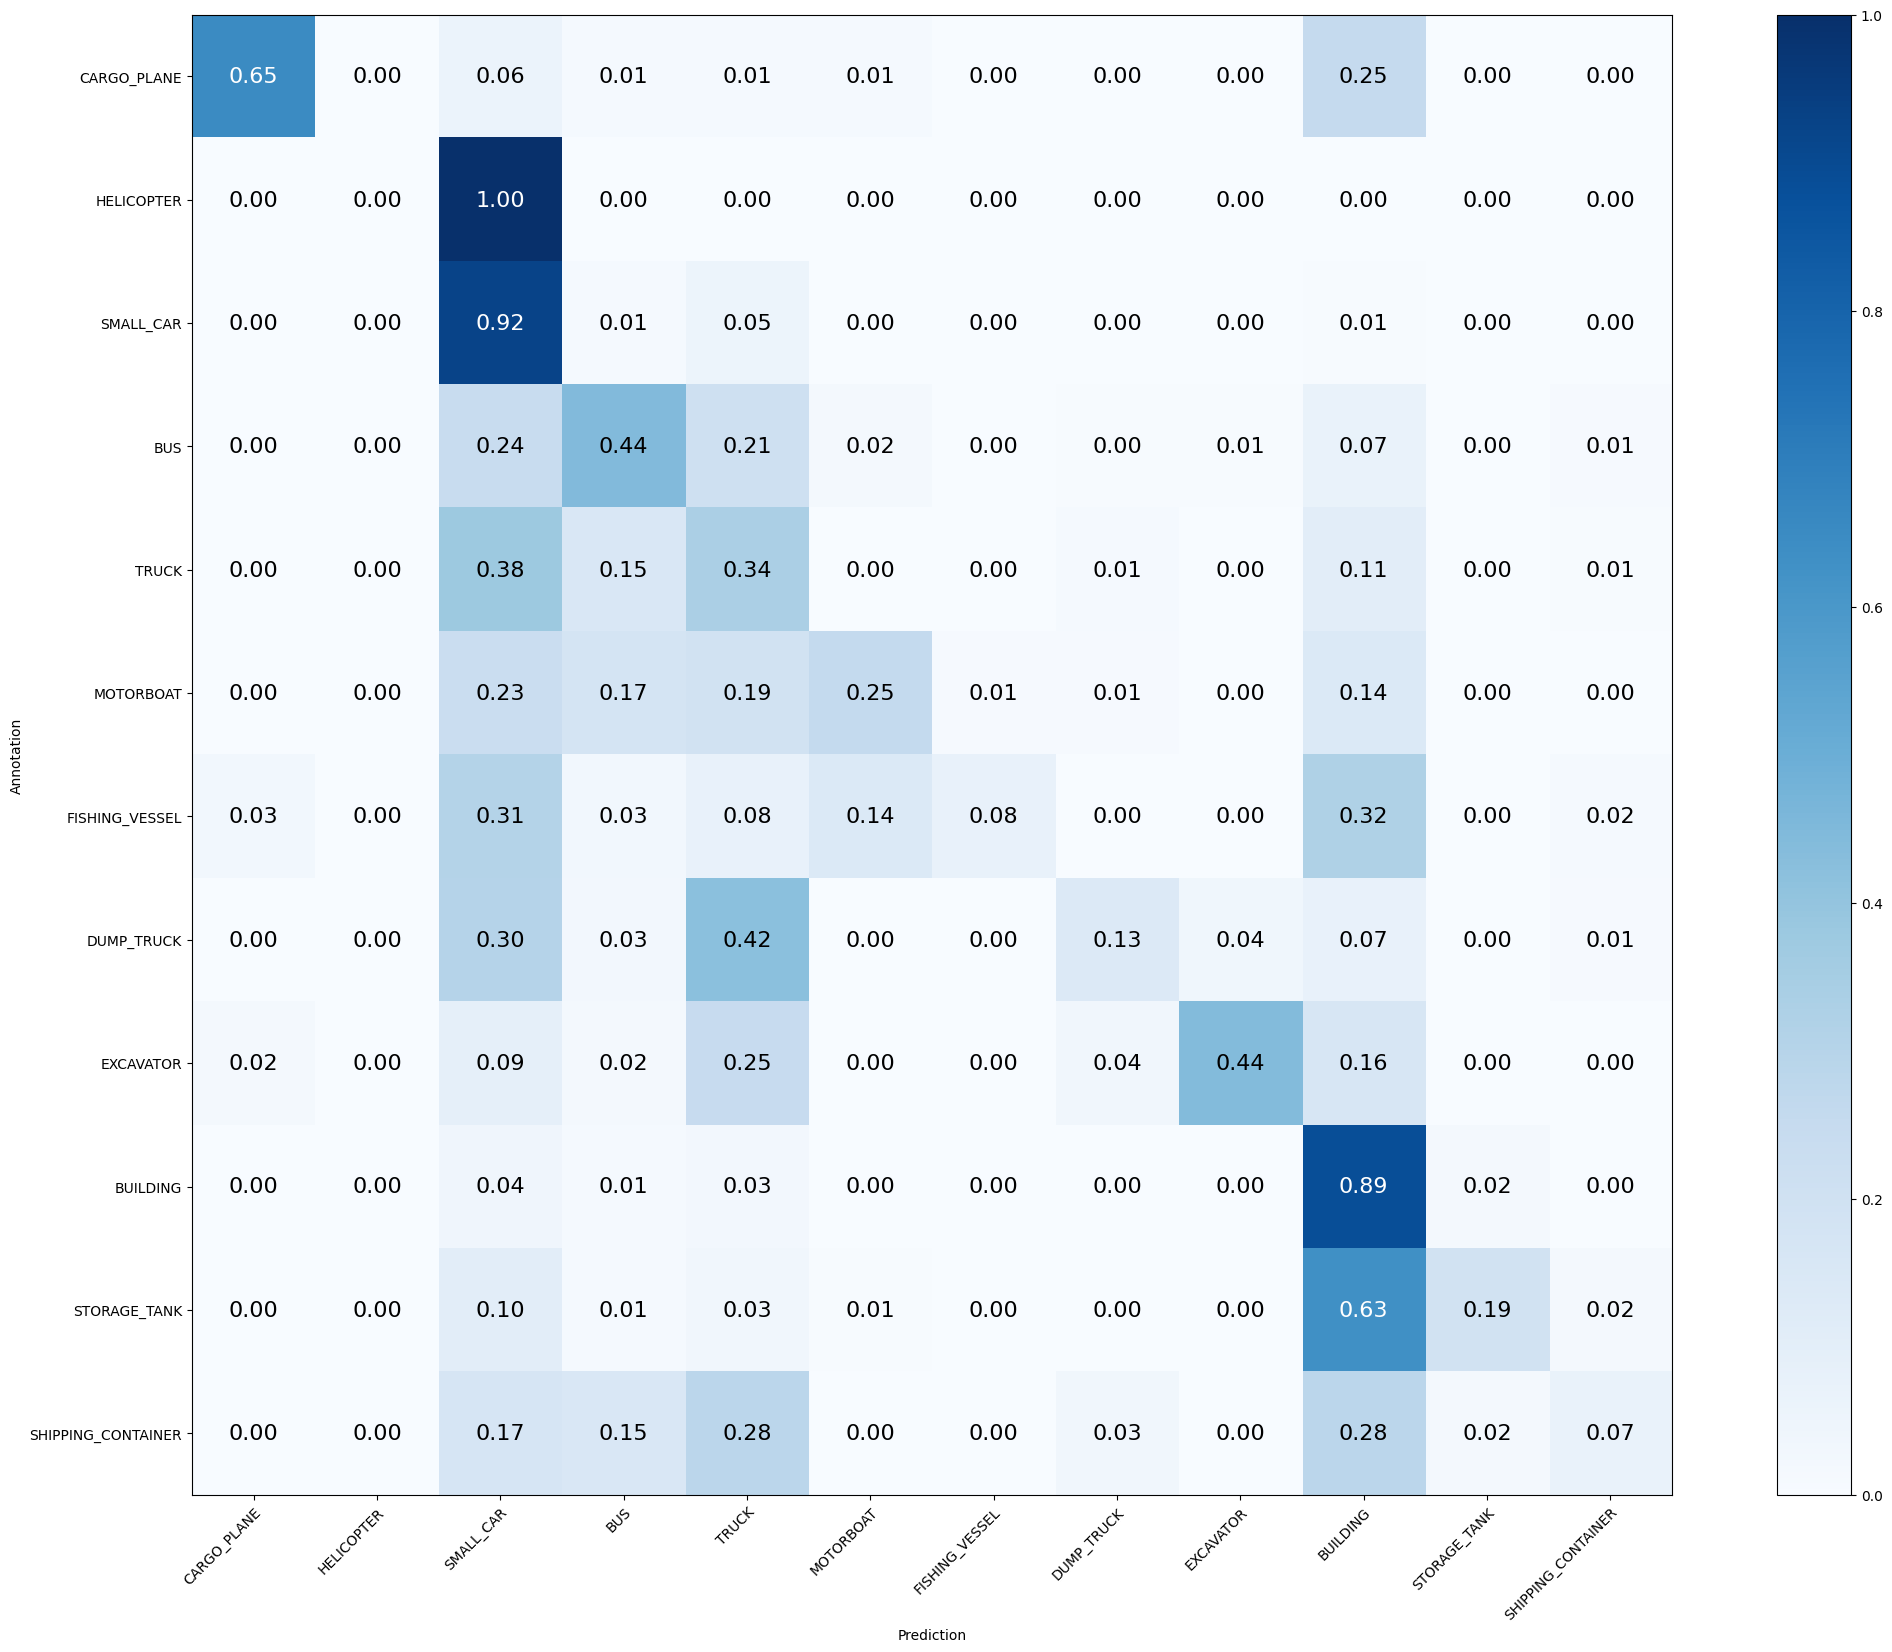

In [18]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
draw_confusion_matrix(cm, categories)

# Note. this notebook was run two times, and the first time it actually classified almost instances as small cars instead of buildings

In [19]:
import numpy as np


# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

Mean Accuracy: 68.976%
Mean Recall: 36.651%
Mean Precision: 51.621%
> CARGO_PLANE: Recall: 65.060% Precision: 87.097% Specificity: 99.830% Dice: 74.483%
> HELICOPTER: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> SMALL_CAR: Recall: 92.431% Precision: 70.535% Specificity: 83.338% Dice: 80.012%
> BUS: Recall: 44.469% Precision: 52.208% Specificity: 95.746% Dice: 48.029%
> TRUCK: Recall: 33.525% Precision: 41.756% Specificity: 92.038% Dice: 37.191%
> MOTORBOAT: Recall: 25.410% Precision: 52.542% Specificity: 99.398% Dice: 34.254%
> FISHING_VESSEL: Recall: 7.692% Precision: 55.556% Specificity: 99.915% Dice: 13.514%
> DUMP_TRUCK: Recall: 13.393% Precision: 38.462% Specificity: 99.486% Dice: 19.868%
> EXCAVATOR: Recall: 43.860% Precision: 73.529% Specificity: 99.809% Dice: 54.945%
> BUILDING: Recall: 88.551% Precision: 82.222% Specificity: 90.839% Dice: 85.269%
> STORAGE_TANK: Recall: 18.750% Precision: 47.368% Specificity: 99.352% Dice: 26.866%
> SHIPPING_CONTAINER:

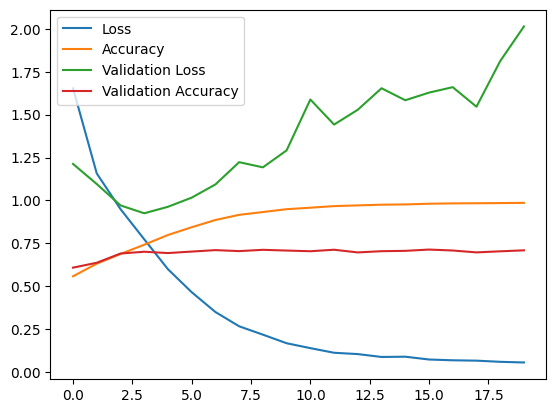

In [20]:
plt.plot(h.history["loss"], label = "Loss")
plt.plot(h.history["accuracy"], label = "Accuracy")
plt.plot(h.history["val_loss"], label = "Validation Loss")
plt.plot(h.history["val_accuracy"], label = "Validation Accuracy")
#handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles, ["loss", "accuracy", "val_loss", "val_accuracy"])
plt.legend()
plt.show()